# **计算摄影学**
# 图像去噪
## 目标
- 学习使用非局部平均值去噪算法去除图像中的噪音
- 学习函数 cv2.fastNlMeansDenoising()， cv2.fastNlMeansDenoisingColored()等  

## 原理
在前面的章节中我们已经学习了很多图像平滑技术，比如高斯平滑，中值平滑等，当噪声比较小时这些技术的效果都是很好的。在这些技术中我们选取像素周围一个小的邻域然后用高斯平均值或者中值平均值取代中心像素。简单来说，像素级别的噪声去除是限制在局部邻域的。  
噪声有一个性质。我们认为噪声是平均值为一的随机变量。考虑一个带噪声的像素点， p = p0 + n，其中 p0 为像素的真实值， n 为这个像素的噪声。我们可以从不同图片中选取大量的相同像素（ N）然后计算平均值。理想情况下我们会得到 p = p0。因为噪声的平均值为 0。  
通过简单的设置我们就可以去除这些噪声。将一个静态摄像头固定在一个位置连续拍摄几秒钟。这样我们就会得到足够多的图像帧，或者同一场景的大量图像。写一段代码求解这些帧的平均值（这对你来说应该是小菜一碟）。将最终结果与第一帧图像对比一下。你会发现噪声减小了。不幸的是这种简单的方法对于摄像头和运动场景并不总是适用。大多数情况下我们只有一张带有噪音的图像。  
想法很简单，我们需要一组相似的图片，通过取平均值的方法可以去除噪音。考虑图像中一个小的窗口（ 5x5），有很大可能图像中的其他区域也存在一个相似的窗口。有时这个相似窗口就在邻域周围。如果我们找到这些相似的窗口并取他们的平均值会怎样呢？对于特定的窗口这样做挺好的。如下图所示。
![](Denoising.png)  
图中的蓝色窗口看起来是相似的。绿色窗口看起来也是相似的。所以我们可以选取包含目标像素的一个小窗口，然后在图像中搜索相似的窗口，最后求取所有窗口的平均值，并用这个值取代目标像素的值。这种方法就是非局部平均值去噪。与我们以前学习的平滑技术相比这种算法要消耗更多的时间，但是结果很好。你可以在更多资源中找到更多的细节和在线演示。
对于彩色图像，要先转换到 CIELAB 颜色空间，然后对 L 和 AB 成分分别去噪。  



## 45.1 OpenCV 中的图像去噪
OpenCV 提供了这种技术的四个变本。  
1. cv2.fastNlMeansDenoising() 使用对象为灰度图。
2. cv2.fastNlMeansDenoisingColored() 使用对象为彩色图。
3. cv2.fastNlMeansDenoisingMulti() 适用于短时间的图像序列（灰度图像）
4. cv2.fastNlMeansDenoisingColoredMulti() 适用于短时间的图像序列（彩色图像）

共同参数有：
- h : 决定过滤器强度。 h 值高可以很好的去除噪声，但也会把图像的细节抹去。 (取 10 的效果不错)
- hForColorComponents : 与 h 相同，但适用于彩色图像。（与h相同）
- templateWindowSize : 奇数。 (推荐值为 7)
- searchWindowSize : 奇数。 (推荐值为 21)

请查看跟多资源获取这些参数的细节。这里我们会演示 2 和 3，其余就留给你了。  

### 45.1.1 cv2.fastNlMeansDenoisingColored()
和上面提到的一样，它可以被用来去除彩色图像的噪声。（假设是高斯噪声）。下面是示例。  

我们的输入图像中含有方差为 25 的噪声，下面是结果。

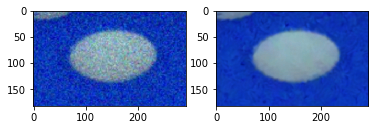

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('die.png')
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.subplot(121),plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122),plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()

### 45.1.2 cv2.fastNlMeansDenoisingMulti()
现在我们要对一段视频使用这个方法。第一个参数是一个噪声帧的列表。第二个参数 imgtoDenoiseIndex 设定那些帧需要去噪，我们可以传入一个帧的索引。第三个参数 temporaWindowSize 可以设置用于去噪的相邻帧的数目，它应该是一个奇数。在这种情况下 temporaWindowSize 帧的图像会被用于去噪，中间的帧就是要去噪的帧。例如，我们传入 5 帧图像，imgT oDenoiseIndex = 2 和 temporalWindowSize = 3。那么第一帧，第二帧，第三帧图像将被用于第二帧图像的去噪。让我们来看一个例子。

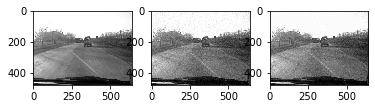

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('v-test.avi')
# create a list of first 5 frames
img = [cap.read()[1] for i in range(5)]
# convert all to grayscale
gray = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in img]
# convert all to float64
gray = [np.float64(i) for i in gray]
# create a noise of variance 25
noise = np.random.randn(*gray[1].shape)*10
# Add this noise to images
noisy = [i+noise for i in gray]
# Convert back to uint8
noisy = [np.uint8(np.clip(i,0,255)) for i in noisy]
# Denoise 3rd frame considering all the 5 frames
dst = cv2.fastNlMeansDenoisingMulti(noisy, 2, 5, None, 4, 7, 35)
plt.subplot(131),plt.imshow(gray[2],'gray')
plt.subplot(132),plt.imshow(noisy[2],'gray')
plt.subplot(133),plt.imshow(dst,'gray')
plt.show()

第一张图是原始图像，第二个是带噪音个图像，第三个是去噪音之后的图像。